# Location based Recommendation System for restaurants and food related businesses to any given user 

## Description of the project:
* The dataset has been taken from : https://www.yelp.com/dataset/download
* It comprises of three data files: reviews data, user data, and business data
* Location Based Recommendation recommendation system has been developed using business data file

# Importing necessary Libraries

In [1]:
import pandas as pd
import json
from sklearn.cluster import KMeans
import numpy as np
from textblob import TextBlob # used to compute polarity of a review text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from sklearn.metrics import silhouette_score 
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


# Loading business data file

In [10]:
business_df = pd.DataFrame()

for chunk in pd.read_json(r"/home/abdys/Downloads/Yelp/yelp_academic_dataset_business.json",chunksize=100000, lines=True):
    business_df = pd.concat([business_df, chunk], ignore_index = True)

business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [11]:
# list of name of attributes in the business dataset along with attributes types
business_df.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [12]:
# number of null values for each attribute
business_df.isna().sum()

business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes      13744
categories        103
hours           23223
dtype: int64

In [13]:
# Some businesses do not contain category information whcih can be seen as follows
null_indices=business_df[business_df['categories'].isnull()].index
print(f'No of businesses that have null categories {len(null_indices)}')
print(f'Indices are as follows: {null_indices.tolist()}') 


No of businesses that have null categories 103
Indices are as follows: [1917, 2243, 3304, 3324, 4640, 5478, 10042, 12526, 13023, 13165, 15060, 17615, 17838, 19190, 19419, 20446, 21567, 22933, 26587, 27640, 28259, 30307, 31014, 31769, 33245, 38638, 39187, 41380, 42434, 42500, 44608, 44984, 46495, 48026, 48373, 48481, 49590, 50428, 56288, 56919, 59256, 59258, 60542, 61144, 63297, 66512, 71424, 71621, 72280, 74453, 78702, 78885, 79828, 83565, 84571, 84701, 85645, 86597, 87394, 88271, 90835, 91090, 91898, 92083, 94406, 95071, 95839, 97584, 99359, 103697, 105401, 107039, 108730, 109702, 112992, 116130, 116167, 116600, 118182, 119889, 121681, 125341, 126415, 128982, 129210, 129402, 130475, 130939, 131689, 132979, 135899, 136025, 136902, 137149, 137150, 138729, 138873, 139352, 144328, 145039, 146058, 148225, 149883]


In [14]:
# printing one particular business index 1917 showing category = None
business_df.iloc[1917] 

business_id           SMYXOLPyM95JvZ-oqnsWUA
name            A A Berlin Glass & Mirror Co
address                60 W White Horse Pike
city                                  Berlin
state                                     NJ
postal_code                            08009
latitude                           39.800416
longitude                         -74.937181
stars                                    3.0
review_count                               5
is_open                                    1
attributes                              None
categories                              None
hours                                   None
Name: 1917, dtype: object

In [15]:
business_df.shape

(150346, 14)

# Identifying the Top 30 (most frequently occuring) Business categories in the Business dataset(business_df)

In [16]:
#printing the comma(,) separated list of different business categories in the business_df
business_df['categories']

0         Doctors, Traditional Chinese Medicine, Naturop...
1         Shipping Centers, Local Services, Notaries, Ma...
2         Department Stores, Shopping, Fashion, Home & G...
3         Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                                 Brewpubs, Breweries, Food
                                ...                        
150341                           Nail Salons, Beauty & Spas
150342    Pets, Nurseries & Gardening, Pet Stores, Hobby...
150343    Shopping, Jewelry, Piercing, Toy Stores, Beaut...
150344    Fitness/Exercise Equipment, Eyewear & Optician...
150345    Beauty & Spas, Permanent Makeup, Piercing, Tattoo
Name: categories, Length: 150346, dtype: object

In [17]:
# splitting on comma(,) to get the different unique categories names
#removing whitespaces from the names of different categories

uniq_cat_dict = {}
for i in business_df.categories:
    cat = [category.strip() for category in str(i).split(',')] # strip() is used to remove whitespaces 
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
# print dictionary formed
print('Printing first 20 elements of the dictionary:')
print(list(uniq_cat_dict.items())[:20])

Printing first 20 elements of the dictionary:
[('Doctors', 3763), ('Traditional Chinese Medicine', 174), ('Naturopathic/Holistic', 221), ('Acupuncture', 424), ('Health & Medical', 11890), ('Nutritionists', 439), ('Shipping Centers', 792), ('Local Services', 11198), ('Notaries', 516), ('Mailbox Centers', 339), ('Printing Services', 790), ('Department Stores', 1430), ('Shopping', 24395), ('Fashion', 5739), ('Home & Garden', 5799), ('Electronics', 1422), ('Furniture Stores', 1597), ('Restaurants', 52268), ('Food', 27781), ('Bubble Tea', 477)]


In [18]:
# forming series dataframe out of dictionary to use in pandas
uniq_cat_series = pd.Series(uniq_cat_dict)
# printing the series
print('printing the series')
uniq_cat_series

printing the series


Doctors                          3763
Traditional Chinese Medicine      174
Naturopathic/Holistic             221
Acupuncture                       424
Health & Medical                11890
                                ...  
Hospitalists                        1
Serbo Croatian                      1
Ceremonial Clothing                 1
Bubble Soccer                       1
Trade Fairs                         1
Length: 1312, dtype: int64

Plotting the count of reviews per unique category from the business dataset


<AxesSubplot: >

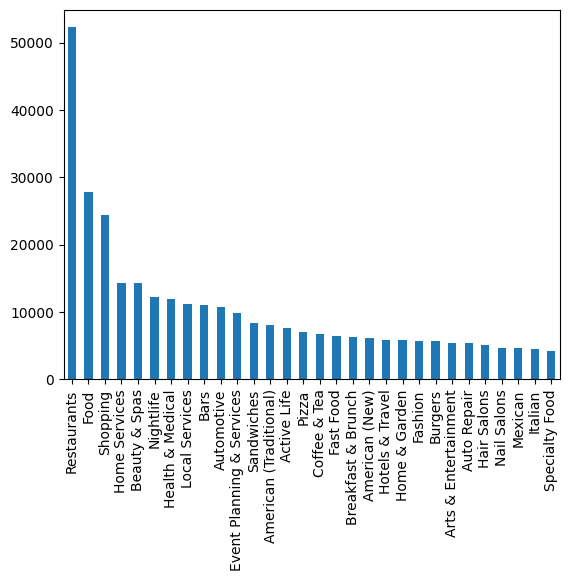

In [19]:
# Plotting the count of business per unique category from the business dataset
print('Plotting the count of reviews per unique category from the business dataset')
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[:30].plot(kind = 'bar')

# Identifying the Top 30 (most frequently occuring) Business category and City in the Business dataset(business_df)

In [20]:
business_city = {}
n = len(business_df)
for i in range(n):
    k1 = str( business_df.categories.iloc[i]).split(',')
    k2 =  business_df.city.iloc[i]
    # given a business, finding the count for it per city
    for j in k1:
        k = (j.strip(),k2)
        if k not in business_city.keys():
            business_city[k] = 1
        else:
            business_city[k] += 1

#Printing the dictionary formed

print('Printing first 20 elements of the dictionary:')
print(list(business_city.items())[:20])

Printing first 20 elements of the dictionary:
[(('Doctors', 'Santa Barbara'), 214), (('Traditional Chinese Medicine', 'Santa Barbara'), 23), (('Naturopathic/Holistic', 'Santa Barbara'), 26), (('Acupuncture', 'Santa Barbara'), 27), (('Health & Medical', 'Santa Barbara'), 509), (('Nutritionists', 'Santa Barbara'), 27), (('Shipping Centers', 'Affton'), 1), (('Local Services', 'Affton'), 3), (('Notaries', 'Affton'), 1), (('Mailbox Centers', 'Affton'), 1), (('Printing Services', 'Affton'), 1), (('Department Stores', 'Tucson'), 85), (('Shopping', 'Tucson'), 1669), (('Fashion', 'Tucson'), 292), (('Home & Garden', 'Tucson'), 437), (('Electronics', 'Tucson'), 118), (('Furniture Stores', 'Tucson'), 120), (('Restaurants', 'Philadelphia'), 5852), (('Food', 'Philadelphia'), 3105), (('Bubble Tea', 'Philadelphia'), 97)]


In [21]:
# forming series dataframe out of dictionary to use in pandas
business_city_series = pd.Series(business_city)
print('printing the series')
business_city_series

printing the series


Doctors                       Santa Barbara    214
Traditional Chinese Medicine  Santa Barbara     23
Naturopathic/Holistic         Santa Barbara     26
Acupuncture                   Santa Barbara     27
Health & Medical              Santa Barbara    509
                                              ... 
Fitness/Exercise Equipment    Edwardsville       1
Beauty & Spas                 Apollo beach       1
Permanent Makeup              Apollo beach       1
Piercing                      Apollo beach       1
Tattoo                        Apollo beach       1
Length: 99289, dtype: int64

<AxesSubplot: >

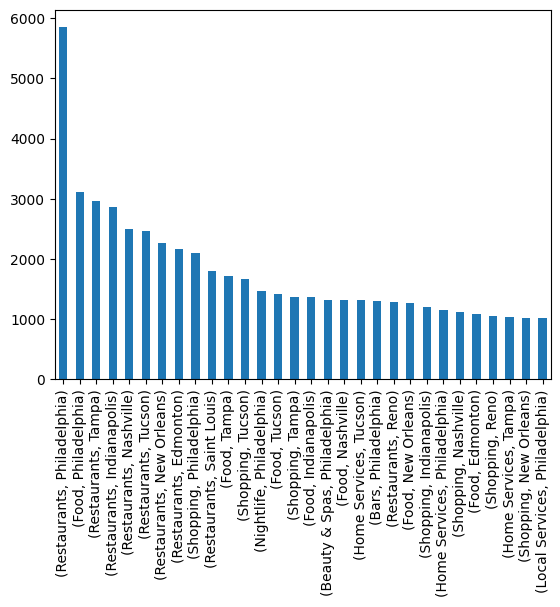

In [22]:
# Plotting the count of (business,city) per unique category from the business dataset
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar')

# Analysis of the above plot

*  The most frequently occuring combination is  (Restaurants, Philadelphia)
* In any given city the business 'Restaurants' occurs most frequently
* The business dataset contains a number of businesses which maybe food related or may belong to some other category like Shopping, Home Services, Nightlife etc

# Dropping businesses whose categories are not given

In [23]:
null_indices = business_df[business_df['categories'].isnull()].index
sub1_bus_df=business_df.dropna()

# Selecting businesses related to Restaurants & Food

In [24]:
# By manual inspection the restaurants and food related categories are given as follows 
specified_categories = [
    'Restaurants', 'Food', 'Bars',
     'Sandwiches', 'American (Traditional)',
     'Coffee & Tea', 'Breakfast & Brunch', 'Fast Food',
    'Pizza', 'American (New)', 'Burgers',  'Mexican',
 'Italian',  'Specialty Food', 'Seafood','Desserts', 'Chinese', 'Bakeries','Salad',
'Chicken Wings', 'Cafes', 'Ice Cream & Frozen Yogurt', 'Wine & Spirits', 'Beer',
]


# Convert specified_categories to a regular expression pattern
pattern = '|'.join(r'\b{}\b'.format(re.escape(cat)) for cat in specified_categories)

# Selecting the rows based on whether the 'categories' column contains any of the specified_categories
sub1_bus_df = sub1_bus_df[sub1_bus_df['categories'].str.contains(pattern, case=False, regex=True)]


# Print the subset dataframe
sub1_bus_df = sub1_bus_df.reset_index(drop=True)
sub1_bus_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56638,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,1,"{'WiFi': ''free'', 'RestaurantsGoodForGroups':...","Cafes, Juice Bars & Smoothies, Coffee & Tea, R...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-17:0', '..."
56639,1jx1sfgjgVg0nM6n3p0xWA,Savaya Coffee Market,11177 N Oracle Rd,Oro Valley,AZ,85737,32.409552,-110.943073,4.5,41,1,"{'BusinessParking': '{'garage': False, 'street...","Specialty Food, Food, Coffee & Tea, Coffee Roa...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-14:0', '..."
56640,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,1,"{'WheelchairAccessible': 'False', 'Restaurants...","Restaurants, Mexican","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
56641,2O2K6SXPWv56amqxCECd4w,The Plum Pit,4405 Pennell Rd,Aston,DE,19014,39.856185,-75.427725,4.5,14,1,"{'RestaurantsDelivery': 'False', 'BusinessAcce...","Restaurants, Comfort Food, Food, Food Trucks, ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


# Finding top 30 cities with Restaurants and Food related businesses

In [25]:
# group the businesses by cities and obtain cumulative count of businesses in each city
df_bus_groups = sub1_bus_df.groupby('city').count()
df_bus_city = df_bus_groups['name']

df_bus_city


city
AVON                  1
Abington             57
Abington Township     1
Affton               21
Afton                 1
                     ..
spring city           1
tucson                1
wilmington            1
wimauma               1
​Clayton              1
Name: name, Length: 952, dtype: int64

# List of cities along with cumulative count of businesses

In [26]:
# sorting the dataframe
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted 

city
Philadelphia    6012
Tampa           3357
Indianapolis    3041
Nashville       2708
Tucson          2685
                ... 
Maryville          1
Marshallton        1
MEDIA              1
MADISON            1
​Clayton           1
Name: name, Length: 952, dtype: int64

<AxesSubplot: xlabel='city'>

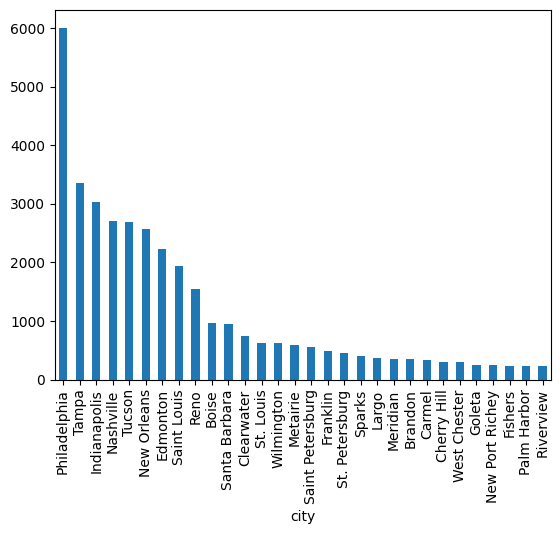

In [27]:
# Plot the 30 (top 30) cities with the highest count of businesses

df_bus_city_sorted[:30].plot(kind = 'bar')

# Selecting top 5 cities (cities with maximum cumulative count) with business categories related to restaurants and food 

In [28]:
# Get the top 5 cities from df_bus_city_sorted

n_city=5

top_k_cities = df_bus_city_sorted.head(n_city).index

# Filter sub_bus_df to retain only rows belonging to the top 5 cities
sub2_bus_df = sub1_bus_df[sub1_bus_df['city'].isin(top_k_cities)]
sub2_bus_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
5,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
7,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
8,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56629,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,Philadelphia,PA,19128,40.032483,-75.214430,3.0,55,1,"{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...","Restaurants, Specialty Food, Food, Sandwiches,...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
56633,8n93L-ilMAsvwUatarykSg,Kitchen Gia,3716 Spruce St,Philadelphia,PA,19104,39.951018,-75.198240,3.0,22,0,"{'RestaurantsGoodForGroups': 'True', 'BikePark...","Coffee & Tea, Food, Sandwiches, American (Trad...","{'Monday': '9:0-19:30', 'Tuesday': '9:0-19:30'..."
56634,AM7O0cwkxm6w_e0Q7-f9FQ,Starbucks,8817 S US-31,Indianapolis,IN,46227,39.638245,-86.128069,4.0,29,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Fal...","Food, Coffee & Tea","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ..."
56635,2MAQeAqmD8enCT2ZYqUgIQ,The Melting Pot - Nashville,"166 2nd Ave N, Ste A",Nashville,TN,37201,36.163875,-86.776311,4.0,204,0,"{'RestaurantsDelivery': 'False', 'RestaurantsR...","Fondue, Beer, Wine & Spirits, Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '16:0-21:0', ..."


In [29]:
sub2_bus_df.shape

(17803, 14)

# Number of businesses in top 5 cities

<AxesSubplot: >

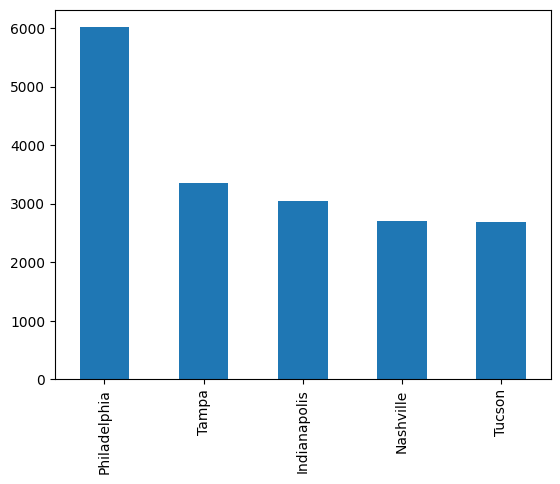

In [30]:
sub2_bus_df['city'].value_counts().plot(kind='bar')

# (Business,City) combination for top 5 cities

<AxesSubplot: >

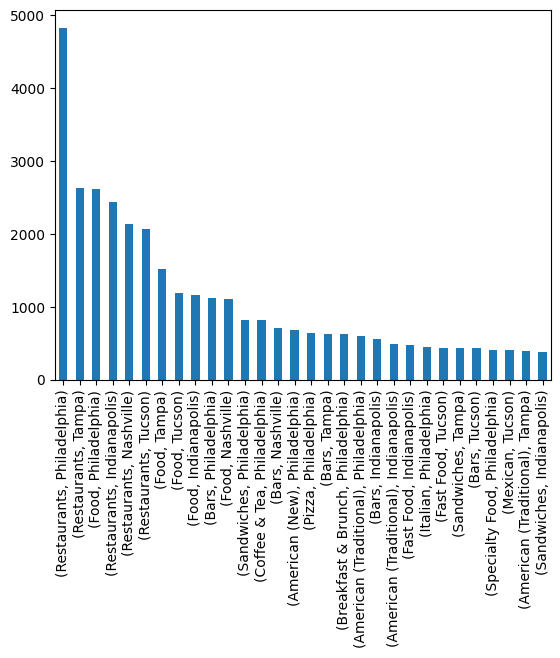

In [31]:
# print buisness,city count only of your specified categories
business_city = {}
n = len(sub2_bus_df )
for i in range(n):
    k1 = str( sub2_bus_df.categories.iloc[i]).split(',')
    k2 =  sub2_bus_df.city.iloc[i]
    for j in k1 :
        if j.strip() in specified_categories:    
            k = (j.strip(),k2)
            if k not in business_city.keys():
                business_city[k] = 1
            else:
                business_city[k] += 1
business_city_series = pd.Series(business_city)
business_city_series.sort_values(ascending = False, inplace = True)
business_city_series[:30].plot(kind = 'bar')

# Populating top_k_cities, with the names of top 3 cities

In [32]:
top_k_cities = df_bus_city_sorted.head(n_city).index
top_k_cities= top_k_cities[:3]
top_k_cities

Index(['Philadelphia', 'Tampa', 'Indianapolis'], dtype='object', name='city')

# Location based Recommendations for Restaurants and food related businesses

### In this part Location based Recommendations has been developed for Restaurants and food related businesses for top 3 cities 

### The businesses contain their location information in form latitude, longitude coordinates 


### The following analysis has been done on a per-city basis for each of the three cities 
 * The data has been divided into train and test in 90:10 ratio
 * The 90% training data has been used to form clusters and the 10% test data has been used for making recommendations
 * To recommend nearby Restaurants and food related businesses to any given user, location based clusters have been formed out of the given businesses using K-Means clustering 
 * As the value of K is not known, the plot of Inertia (SSE) vs K is used to determine the optimal K value to be used for our analysis
 * Further for each value of K, the silhouette score has been calculated to check the goodness of the cluster with the respective K value 
 * After forming the location based clusters, these are used for making KNN based nearest neighbors recommendation for nearest 5 Restaurants and food related businesses in the proximity of the user location (latitude, longitude)


# Location based Recommendations for first city in top 3- Philadelphia

# Populating a dataframe for specific businesses of City 1 (Philadelphia)

In [33]:
city_1=top_k_cities[0]
city1_df=sub2_bus_df[sub2_bus_df['city']==city_1]
city1_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
7,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
8,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
13,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
15,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,4105 Main St,Philadelphia,PA,19127,40.022466,-75.218314,3.0,41,0,"{'RestaurantsReservations': 'False', 'Caters':...","Pizza, Restaurants, Salad, Soup","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56603,OfRbGvHn-nAnQMqNxiIpcA,Grilly Cheese,3306 Arch St,Philadelphia,PA,19104,39.957447,-75.189916,3.0,5,1,"{'BikeParking': 'True', 'WheelchairAccessible'...","Specialty Food, Event Planning & Services, Res...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
56628,gPr1io7ks0Eo3FDsnDTYfg,Tata Cafe,7201 Germantown Ave,Philadelphia,PA,19119,40.060414,-75.191084,4.0,21,0,"{'RestaurantsGoodForGroups': 'True', 'Business...","Sandwiches, Restaurants, Italian","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ..."
56629,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,Philadelphia,PA,19128,40.032483,-75.214430,3.0,55,1,"{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...","Restaurants, Specialty Food, Food, Sandwiches,...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
56633,8n93L-ilMAsvwUatarykSg,Kitchen Gia,3716 Spruce St,Philadelphia,PA,19104,39.951018,-75.198240,3.0,22,0,"{'RestaurantsGoodForGroups': 'True', 'BikePark...","Coffee & Tea, Food, Sandwiches, American (Trad...","{'Monday': '9:0-19:30', 'Tuesday': '9:0-19:30'..."


In [34]:
# list of name of attributes for the city1_df  along with attributes types
city1_df.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [35]:
# number of null values for each attribute
city1_df.isna().sum() 

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

# Identifying the Top (most frequently occuring) Business categories in the city1_df dataframe

In [36]:

# Initialize a dictionary to store counts
category_counts_city1 = defaultdict(int)

# Iterate through categories in city1_df
for categories_str in city1_df.categories:
    categories = categories_str.split(', ')
    for category in categories:
        category=category.strip()
        # Check if the category is one of the specified categories
        if category in specified_categories:
            # Increment the count for the specified category
            category_counts_city1[category] += 1

# Print counts for each specified category
print('Printing first 20 elements of the dictionary:')
print(list(category_counts_city1 .items())[:20])

Printing first 20 elements of the dictionary:
[('Restaurants', 4829), ('Food', 2611), ('Coffee & Tea', 822), ('Bakeries', 318), ('Bars', 1118), ('Italian', 449), ('Pizza', 644), ('Salad', 265), ('American (Traditional)', 596), ('Sandwiches', 825), ('Chinese', 351), ('Seafood', 309), ('Burgers', 333), ('Fast Food', 318), ('Breakfast & Brunch', 621), ('Cafes', 291), ('Specialty Food', 410), ('American (New)', 677), ('Beer', 233), ('Wine & Spirits', 233)]


<AxesSubplot: xlabel='Category'>

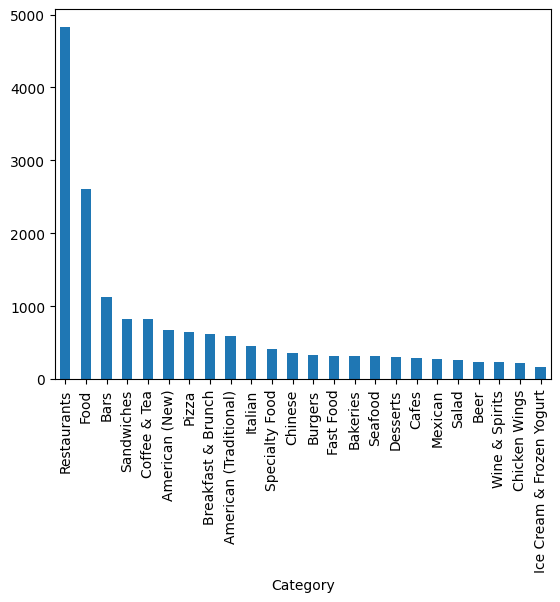

In [37]:
# forming  dataframe out of dictionary to use in pandas
df_cat_city1 = pd.DataFrame(list(category_counts_city1.items()), columns=['Category', 'Count'])
# sorting based on number of counts
df_cat_city1=df_cat_city1.sort_values(by='Count',ascending=False)
# plotting the category count plot for each business in city1
df_cat_city1.plot(x='Category', y='Count', kind='bar',  legend=None)

# Analysis of the plot above:


### The restaurant business is most popular, followed by Food and Bars


# Train-Test Split formation from city1_df (city specific businesses) for the City 1 (Philadelphia) 

In [38]:
city1bus_train, city1bus_test = train_test_split(city1_df, test_size=0.1, random_state=42)
city1bus_train.shape, city1bus_test.shape

((5410, 14), (602, 14))

# Determining no of Clusters (value of K ) for K-Means using the plot of Inertia (SSE) v/s K in Elbow method 


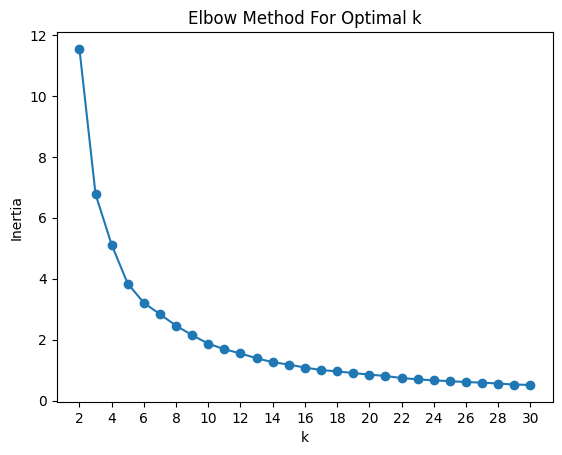

In [39]:
# Elbow method to determine the value of K in K-Means Clustering
coords = city1bus_train[['longitude','latitude']]

distortions = []
# the values of inertia have been calculated with K ranging from 2 to 30
K = range(2,31)
for k in K:
    kmeansModel = KMeans(n_clusters=k, random_state=42)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)


     

fig, ax = plt.subplots()
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(2, 31,2))
plt.title('Elbow Method For Optimal k')
#plt.savefig('elbow.png')
plt.show()
     

 # Determining the goodness of clusters for each K value using Silhouette score

[0.6456861734387027,
 0.6103107902599842,
 0.5147306010784597,
 0.5086399940679531,
 0.4795724876944072,
 0.4746953812450548,
 0.4761705732407705,
 0.45271558376798493,
 0.43164526645342866,
 0.40126868065921634,
 0.42431042982722045,
 0.4210092256822744,
 0.42263392201257083,
 0.4158283766227927,
 0.4325973872495793,
 0.43314096856132484,
 0.42431036272917955,
 0.43823080618070465,
 0.4293131555736626,
 0.4197806307580011,
 0.431010362144526,
 0.43176091430944136,
 0.4340080740566686,
 0.42870221904154454,
 0.4282247808318534,
 0.45278114183831564,
 0.43687440215620343,
 0.43163850172578416,
 0.44917823761795905]

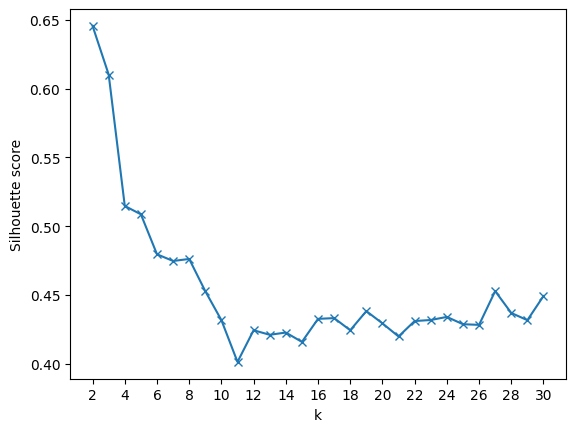

In [40]:
coords = city1bus_train[['longitude','latitude']]

sil = []

K = range(2,31)
for k in K:
  kmeans = KMeans(n_clusters = k,random_state=42).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

plt.plot(K, sil, marker='x', label='Silhouette Score')
plt.ylabel('Silhouette score')
plt.xlabel('k')
plt.xticks(range(2, 31,2))
sil

# Selecting appropriate value of K using silhouette score and inertia

In [41]:
pd.DataFrame({'silhouette_score':sil,'Inertia':distortions},index=K)

,silhouette_score,Inertia
2,0.645686,11.540410
3,0.610311,6.772304
4,0.514731,5.113148
5,0.508640,3.836334
6,0.479572,3.208739
7,0.474695,2.834041
8,0.476171,2.457187
9,0.452716,2.147290
10,0.431645,1.867198
11,0.401269,1.686785


# Analysis for selecting K from above:


### We observe that beyond K=8, the silhouette score and the inertia (SSE) are broadly stable and so we use K=8 


# Clustering with K=8 for the City 1 (Philadelphia) 

In [42]:

coords = city1bus_train[['longitude','latitude']]

k=8
city1_kmeans = KMeans(n_clusters=k, random_state=42)
city1_kmeans =city1_kmeans.fit(coords)
y = city1_kmeans.labels_
city1bus_train['cluster_no']=y 

cluster_centers_city1 = city1_kmeans.cluster_centers_



# Plotting the 8 clusters for the City 1 (Philadelphia) using (latitude, longitude) coordinates    

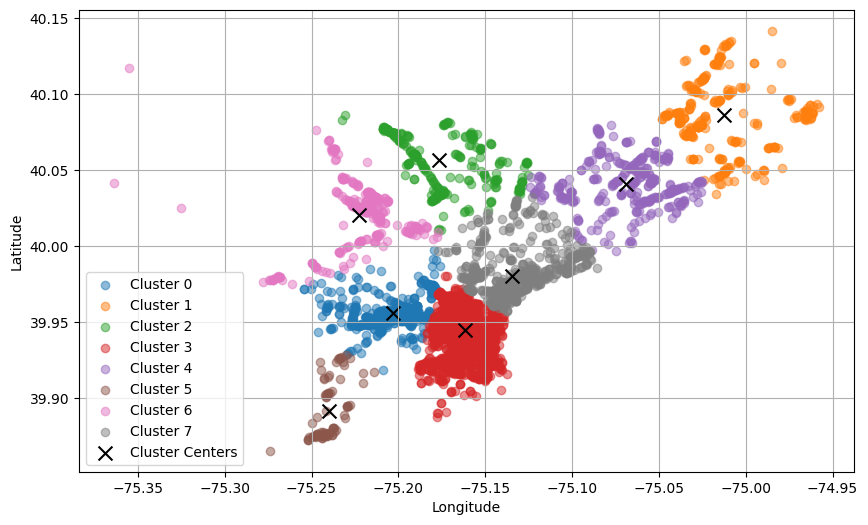

In [43]:
plt.figure(figsize=(10, 6))

# Plot each data point
for cluster_label in range(k):
    plt.scatter(city1bus_train.loc[city1bus_train['cluster_no'] == cluster_label, 'longitude'], 
                city1bus_train.loc[city1bus_train['cluster_no'] == cluster_label, 'latitude'], 
                label=f'Cluster {cluster_label}', alpha=0.5)

# Plot cluster centers
plt.scatter(cluster_centers_city1[:, 0], cluster_centers_city1[:, 1], marker='x', color='black',s=100, label='Cluster Centers',alpha=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('KMeans Clustering of City1bus Data')
plt.legend()
plt.grid(True)
plt.show()


# Using the business locations from the test data (10%) to generate locations for new users wanting location based recommendations

The given user data does not have user locations. So the locations from the unseen data (10%) of businesses of the respective city are used to populate city1user_test data that contains the user id (index of the row) and the user locations (latitude, longitude)

In [44]:
city1user_test=city1bus_test[['longitude','latitude']].reset_index(drop=True)
# 602 unseen users with their locations have been populated in city1user_test
city1user_test 

,longitude,latitude
0,-75.188066,39.920544
1,-75.177657,39.967002
2,-75.150777,39.940475
3,-75.166864,39.950227
4,-75.150103,39.938371
...,...,...
597,-75.268611,39.980047
598,-75.033565,40.076620
599,-75.150898,39.942408
600,-75.182574,39.938817


# The visualisation for the distribution of new/unseen users wrt to the clusters formed earlier, the cluster centers shown by 'X' designate the cluster centers of the clusters formed from the training data

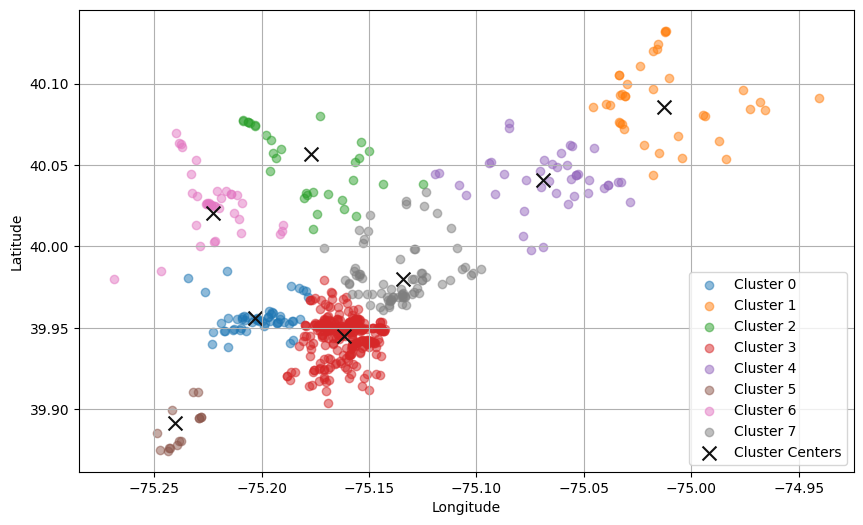

In [45]:
X=city1user_test[['longitude','latitude']]
cluster_pred=city1_kmeans.predict(X)

plt.figure(figsize=(10, 6))

# Plot each cluster separately
for cluster_label in range(city1_kmeans.n_clusters):
    cluster_X = X[cluster_pred == cluster_label]
    plt.scatter(cluster_X['longitude'], cluster_X['latitude'], label=f'Cluster {cluster_label}', alpha=0.5)

# Plot cluster centers
plt.scatter(city1_kmeans.cluster_centers_[:, 0], city1_kmeans.cluster_centers_[:, 1], marker='x', color='#111111',s=100, label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('KMeans Clustering of City1_test Data')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of the above plot:


### We want to highlight that the new/unseen users show a uniform distribution across all the original 8 clusters 


### Thus illustrating that our unseen users belong to all 8 clusters formed and are not placed in just 1 or 2 clusters formed on the training data

# Making the location based Recommendation for new/unseen users 


### For this loc_based() function has been coded as follows: 
 * For a given user id from city1user_test, we fetch the location coordinates  
 * We use the trained K-Means model to predict cluster for this user id
 * Once we get the cluster we fetch all the businesses belonging to that cluster
 * We then apply KNN to get distance of the given user id to all the businesses belonging to that cluster
 * The businesses are sorted based on increasing order of distances and we select the nearest 5 businesses as location based recommendation for the given user id   

In [46]:
def euclidean_distance(coord1, coord2):
    return np.sqrt(np.sum((coord1 - coord2)**2))


def loc_based(user_id_num,citybus_test,citybus_train,city_kmeans,rec_k=5):

    sample_data = citybus_test[['longitude','latitude']].iloc[user_id_num]

    predicted_cluster_no = city_kmeans.predict([sample_data])[0]


    same_cluster_bus=citybus_train[citybus_train['cluster_no']==predicted_cluster_no]
    same_cluster_bus['distance_from_user'] = same_cluster_bus.apply(lambda row: euclidean_distance(row[['longitude','latitude']], sample_data), axis=1)

    same_cluster_bus = same_cluster_bus.sort_values(by='distance_from_user')

    if len(same_cluster_bus)<rec_k:
        return same_cluster_bus
    
    else:
        return same_cluster_bus[:rec_k]




# Location Based Recommendation (LBR) for a new/unseen user

# Example: Location Based Recommendation for user id =5

In [47]:
# selecting any user for making LBR, let user id = 5
user_id_num=5
buisness_rec_city1=loc_based(user_id_num,city1user_test,city1bus_train,city1_kmeans,rec_k=5)
test_user_loc = city1user_test[['longitude','latitude']].iloc[user_id_num]
print(f'Location of user id {user_id_num}:{test_user_loc} ')
buisness_rec_city1

Location of user id 5:longitude   -75.172753
latitude     40.080120
Name: 5, dtype: float64 


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cluster_no,distance_from_user
11847,Fyi_Mf7UsTNVNQii-RGzTA,Philly Pretzel Factory,1555 E Wadsworth Ave,Philadelphia,PA,19150,40.080441,-75.173092,3.5,6,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...","Bakeries, Food, Restaurants, Pretzels, Hot Dogs","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",2,0.000467
21808,_QqLPONYQiUu3u7VsbYhQg,Wadsworth Pizzeria,1523 E Wadsworth Ave,Philadelphia,PA,19150,40.079878,-75.173539,2.0,24,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Pizza","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",2,0.000822
4828,ceSjm0nHamTmAd1tWcuDhw,Bread & Butter Philly - Breakfast Junction,1517 E Wadsworth Ave,Philadelphia,PA,19150,40.079791,-75.173624,4.5,22,1,"{'RestaurantsPriceRange2': '1', 'RestaurantsTa...","Food, American (Traditional), Breakfast & Brun...","{'Monday': '6:0-15:0', 'Tuesday': '6:0-15:0', ...",2,0.000931
46260,0WJRKvGsX3NdoNdZuDFlWg,Bilal's Garden,1525 Wadsworth Ave,Philadelphia,PA,19150,40.079880,-75.173660,3.0,11,0,"{'GoodForKids': 'True', 'RestaurantsPriceRange...","Restaurants, Barbeque, Soul Food, Seafood","{'Monday': '11:0-23:15', 'Tuesday': '11:0-23:1...",2,0.000938
20746,2-oXhioK5KFCSUVNjv2GCg,Baskin-Robbins,1630 E Wadsworth Ave,Philadelphia,PA,19150,40.080987,-75.172078,2.5,5,1,"{'RestaurantsPriceRange2': '1', 'RestaurantsDe...","Ice Cream & Frozen Yogurt, Food","{'Monday': '5:0-22:0', 'Tuesday': '5:0-22:0', ...",2,0.001100


# Final Location Based Recommendation for user id =5

In [48]:
buisness_rec_city1 = buisness_rec_city1.rename(columns={'name': 'business_name'})[['business_name', 'categories']].reset_index(drop=True)
buisness_rec_city1

,business_name,categories
0,Philly Pretzel Factory,"Bakeries, Food, Restaurants, Pretzels, Hot Dogs"
1,Wadsworth Pizzeria,"Restaurants, Pizza"
2,Bread & Butter Philly - Breakfast Junction,"Food, American (Traditional), Breakfast & Brun..."
3,Bilal's Garden,"Restaurants, Barbeque, Soul Food, Seafood"
4,Baskin-Robbins,"Ice Cream & Frozen Yogurt, Food"


# Example: Location Based Recommendation for user id =400

In [49]:
# selecting any user for making LBR, let user id = 400
user_id_num=400
buisness_rec_city1=loc_based(user_id_num,city1user_test,city1bus_train,city1_kmeans,rec_k=5)
test_user_loc = city1user_test[['longitude','latitude']].iloc[user_id_num]
print(f'Location of user id {user_id_num}:{test_user_loc} ')
buisness_rec_city1

Location of user id 400:longitude   -75.168707
latitude     39.918040
Name: 400, dtype: float64 


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cluster_no,distance_from_user
24737,9g7_oSVUYnquy6w3ocZyAA,Li'l Nick's Deli,1311 W Moyamensing Ave,Philadelphia,PA,19148,39.918657,-75.169555,5.0,17,1,"{'NoiseLevel': 'u'average'', 'RestaurantsReser...","Restaurants, Delis","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ...",3,0.001049
15124,LCXRkGG1RhisKLVTHH3jiQ,Asian Fusion & Steak,2647 S 13th St,Philadelphia,PA,19148,39.916762,-75.169005,3.5,43,1,"{'RestaurantsReservations': 'False', 'Caters':...","Chinese, Asian Fusion, Restaurants, Sushi Bars","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",3,0.001312
6284,mJ_itjZYQ_OA71q2NaWE4Q,Carangi Baking,2655 S Iseminger St,Philadelphia,PA,19148,39.916633,-75.168503,4.5,34,1,"{'RestaurantsReservations': 'False', 'BikePark...","Bakeries, Cafes, Food, Sandwiches, Restaurants...","{'Monday': '6:0-18:0', 'Tuesday': '6:0-18:0', ...",3,0.001422
5396,y_JZFlF-4fwSIn4RJ2vMGw,Italiano's,2551 S 12th St,Philadelphia,PA,19148,39.917764,-75.167158,4.5,51,1,"{'Ambience': '{'romantic': False, 'intimate': ...","Desserts, Restaurants, Italian, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '19:0-22:0', ...",3,0.001573
25361,24xx8ju_U_uN1zJf2YtKkA,The Black Cat Tavern On 12th,2654 S 12th St,Philadelphia,PA,19148,39.916540,-75.167774,5.0,40,1,"{'HappyHour': 'True', 'GoodForKids': 'False', ...","Beer Bar, Dive Bars, Gastropubs, Cocktail Bars...","{'Wednesday': '16:0-23:0', 'Thursday': '16:0-2...",3,0.001767


#  Final Location Based Recommendation for user id =400

In [50]:
buisness_rec_city1 = buisness_rec_city1.rename(columns={'name': 'business_name'})[['business_name', 'categories']].reset_index(drop=True)
buisness_rec_city1

,business_name,categories
0,Li'l Nick's Deli,"Restaurants, Delis"
1,Asian Fusion & Steak,"Chinese, Asian Fusion, Restaurants, Sushi Bars"
2,Carangi Baking,"Bakeries, Cafes, Food, Sandwiches, Restaurants..."
3,Italiano's,"Desserts, Restaurants, Italian, Food, Ice Crea..."
4,The Black Cat Tavern On 12th,"Beer Bar, Dive Bars, Gastropubs, Cocktail Bars..."


# Location based Recommendations for second city in top 3- Tampa

# Populating a dataframe for specific businesses of City 2 (Tampa)

In [51]:
city_2=top_k_cities[1]
city2_df=sub2_bus_df[sub2_bus_df['city']==city_2]
city2_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
26,uI9XODGY_2_ieTE6xJ0myw,Roman Forum,10440 N Dale Mabry Hwy,Tampa,FL,33618,28.046203,-82.505053,4.0,23,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, American (New), Italian","{'Monday': '11:30-21:0', 'Tuesday': '11:30-21:..."
27,JgpnXv_0XhV3SfbfB50nxw,Joe's Pizza,2038 N Dale Mabry Hwy,Tampa,FL,33607,27.960514,-82.506127,4.0,35,0,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Pizza","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
40,RK6-cJ9hj53RzOlCBmpT-g,Impasto,,Tampa,FL,33611,27.890814,-82.502346,5.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Italian, Food Trucks, Food","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
58,zFvqulgAYOpSG2t1v8AZ-w,The Cake Drip,1625 W Snow Cir,Tampa,FL,33606,27.935753,-82.476470,4.0,40,1,"{'RestaurantsDelivery': 'False', 'RestaurantsT...","Desserts, Do-It-Yourself Food, Food, Patisseri...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21..."
73,QjV4v7q_pt7tt3K1US7IHg,PDQ Temple Terrace,5112 E Fowler Ave,Tampa,FL,33617,28.054888,-82.399548,3.0,5,1,"{'RestaurantsReservations': 'False', 'Business...","Fast Food, Sandwiches, Chicken Shop, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56488,M5eciMJjAiEmwI_TUWrU1w,New Leaf Cafe,11813 N Armenia Ave,Tampa,FL,33612,28.057322,-82.479585,4.5,21,1,"{'BusinessAcceptsBitcoin': 'False', 'OutdoorSe...","Gift Shops, Specialty Food, Flowers & Gifts, B...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-16:0', ..."
56537,hezQG50YXqdgxkhl2R9OuQ,Taco Bell,7620 West Hillsborough Avenue,Tampa,FL,33615,27.996400,-82.565400,1.5,30,1,"{'OutdoorSeating': 'False', 'RestaurantsTakeOu...","Fast Food, Restaurants, Breakfast & Brunch, Ta...","{'Monday': '8:0-1:0', 'Tuesday': '8:0-1:0', 'W..."
56547,MRGIaZmmpY38WbhVq29qZA,El Patio,5425 Sheldon Rd,Tampa,FL,33615,27.997949,-82.582649,3.0,6,1,"{'RestaurantsDelivery': 'False', 'GoodForKids'...","Restaurants, Food Stands, Spanish, Caribbean","{'Wednesday': '11:0-19:0', 'Thursday': '11:0-1..."
56553,ny1N_Py01kVoGOvL9oKjMQ,Cask Social Kitchen,208 S Howard Ave,Tampa,FL,33606,27.942668,-82.482716,4.0,578,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Breakfast & Brunch, Restaurants, Southern, Ame...","{'Tuesday': '16:0-21:0', 'Wednesday': '16:0-21..."


In [52]:
# list of name of attributes for the city2_df  along with attributes types
city2_df.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [53]:
# number of null values for each attribute
city2_df.isna().sum() 

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

# Identifying the Top (most frequently occuring) Business categories in the city2_df dataframe

In [54]:

# Initialize a dictionary to store counts
category_counts_city2 = defaultdict(int)

# Iterate through categories in city1_df
for categories_str in city2_df.categories:
    categories = categories_str.split(', ')
    for category in categories:
        category=category.strip()
        # Check if the category is one of the specified categories
        if category in specified_categories:
            # Increment the count for the specified category
            category_counts_city2[category] += 1

# Print counts for each specified category
category_counts_city2
print('Printing first 20 elements of the dictionary:')
print(list(category_counts_city2.items())[:20])

Printing first 20 elements of the dictionary:
[('Restaurants', 2628), ('American (New)', 315), ('Italian', 197), ('Pizza', 267), ('Food', 1518), ('Desserts', 175), ('Fast Food', 318), ('Sandwiches', 431), ('Bars', 628), ('Salad', 183), ('Burgers', 264), ('Breakfast & Brunch', 311), ('Coffee & Tea', 369), ('Cafes', 203), ('Seafood', 204), ('Specialty Food', 238), ('Mexican', 206), ('Bakeries', 146), ('Ice Cream & Frozen Yogurt', 139), ('American (Traditional)', 389)]


<AxesSubplot: xlabel='Category'>

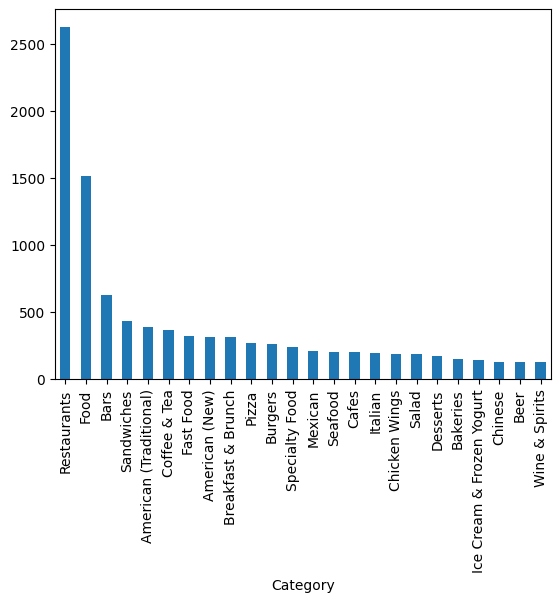

In [55]:
# forming  dataframe out of dictionary to use in pandas
df_cat_city2 = pd.DataFrame(list(category_counts_city2.items()), columns=['Category', 'Count'])
# sorting based on number of counts
df_cat_city2=df_cat_city2.sort_values(by='Count',ascending=False)
# plotting the category count plot for each business in city2
df_cat_city2.plot(x='Category', y='Count', kind='bar',  legend=None)

# Analysis of the plot above: 


### The restaurant business is most popular, followed by Food and Bars

# Train-Test Split formation from city2_df (city specific businesses) for the City 2 (Tampa) 

In [56]:
city2bus_train, city2bus_test = train_test_split(city2_df, test_size=0.1, random_state=42)
city2bus_train.shape, city2bus_test.shape

((3021, 14), (336, 14))

# Determining no of Clusters (value of K ) for K-Means using the plot of Inertia (SSE) v/s K in Elbow method 


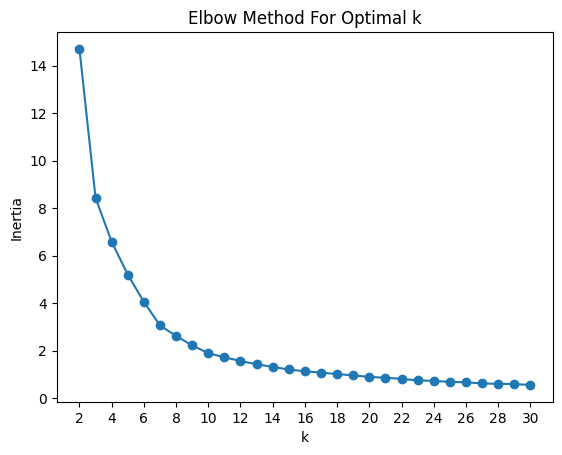

In [57]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = city2bus_train[['longitude','latitude']]

distortions = []
# the values of inertia have been calculated with K ranging from 2 to 30
K = range(2,31)
for k in K:
    kmeansModel = KMeans(n_clusters=k,random_state=42)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)


     

fig, ax = plt.subplots()
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(2, 31,2))
plt.title('Elbow Method For Optimal k')
#plt.savefig('elbow.png')
plt.show()
     

 # Determining the goodness of clusters for each K value using Silhouette score

[0.39372636698954194,
 0.468444584687772,
 0.4044648982539402,
 0.4152560492392416,
 0.4336377514771128,
 0.45240495507116907,
 0.45676529536223925,
 0.47287727274885727,
 0.4701993768309052,
 0.4624021036889829,
 0.45469586082489405,
 0.450764369484654,
 0.4576862166713743,
 0.45562778765805173,
 0.46192254437505764,
 0.4475633785761234,
 0.47138219925461433,
 0.4271083224135194,
 0.4570097869555502,
 0.4295940611096674,
 0.43908154670806776,
 0.45372175254899255,
 0.4542776710027472,
 0.459447563492921,
 0.46094968406341646,
 0.46886130978440677,
 0.4668302137989872,
 0.4632428705025388,
 0.47741065530983545]

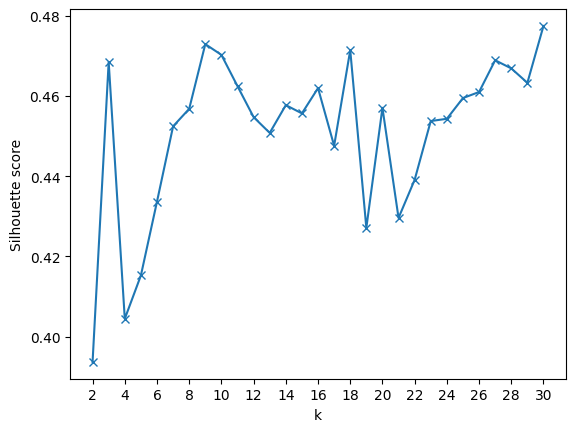

In [58]:
from sklearn.metrics import silhouette_score
coords = city2bus_train[['longitude','latitude']]

sil = []

K = range(2,31)
for k in K:
  kmeans = KMeans(n_clusters = k,random_state=42).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

plt.plot(K, sil, marker='x', label='Silhouette Score')
plt.ylabel('Silhouette score')
plt.xlabel('k')
plt.xticks(range(2, 31,2))
sil

# Selecting appropriate value of K using silhouette score and inertia

In [59]:
pd.DataFrame({'silhouette_score':sil,'Inertia':distortions},index=K)

,silhouette_score,Inertia
2,0.393726,14.701078
3,0.468445,8.427666
4,0.404465,6.585743
5,0.415256,5.199178
6,0.433638,4.052377
7,0.452405,3.059945
8,0.456765,2.616719
9,0.472877,2.217049
10,0.470199,1.893974
11,0.462402,1.718972


# Analysis for selecting K from above: 


### we observe that beyond K=10, the silhouette score and the inertia (SSE) are broadly stable and so we use K=10 


In [60]:

coords = city2bus_train[['longitude','latitude']]

k=10 
city2_kmeans = KMeans(n_clusters=k,random_state=42)
city2_kmeans =city2_kmeans.fit(coords)
y = city2_kmeans.labels_
city2bus_train['cluster_no']=y 

cluster_centers_city2 = city2_kmeans.cluster_centers_



# Plotting the 10 clusters for the City 2 (Tampa) using (latitude, longitude) coordinates  

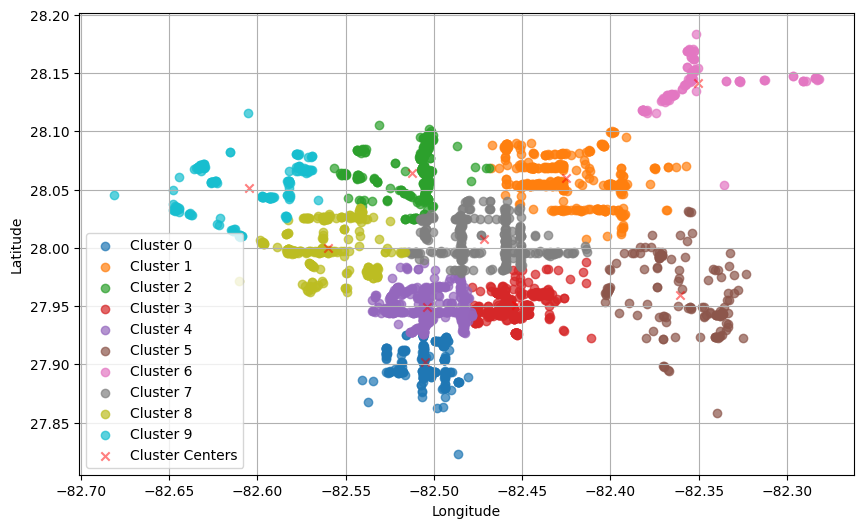

In [61]:
plt.figure(figsize=(10, 6))

# Plot each data point
for cluster_label in range(k):
    plt.scatter(city2bus_train.loc[city2bus_train['cluster_no'] == cluster_label, 'longitude'], 
                city2bus_train.loc[city2bus_train['cluster_no'] == cluster_label, 'latitude'], 
                label=f'Cluster {cluster_label}', alpha=0.7)

# Plot cluster centers
plt.scatter(cluster_centers_city2[:, 0], cluster_centers_city2[:, 1], marker='x', color='red', label='Cluster Centers',alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('KMeans Clustering of City1bus Data')
plt.legend()
plt.grid(True)
plt.show()


# Using the buisness locations from the test data (10%) to generate locations for new users wanting location based recommendations

The given user data does not have user locations. So the locations from the unseen data (10%) of businesses of the respective city are used to populate city2user_test data that contains the user id (index of the row) and the user locations (latitude, longitude)

In [62]:
city2user_test=city2bus_test[['longitude','latitude']].reset_index(drop=True)
city2user_test

,longitude,latitude
0,-82.504050,27.934752
1,-82.458467,27.946251
2,-82.506030,27.892900
3,-82.539579,28.085833
4,-82.576808,28.069684
...,...,...
331,-82.483260,27.942040
332,-82.532745,27.945616
333,-82.582138,28.057125
334,-82.460280,28.068663


# The visualisation for the distribution of new/unseen users wrt to the clusters formed earlier, the cluster centers shown by 'X' designate the cluster centers of the clusters formed from the training data

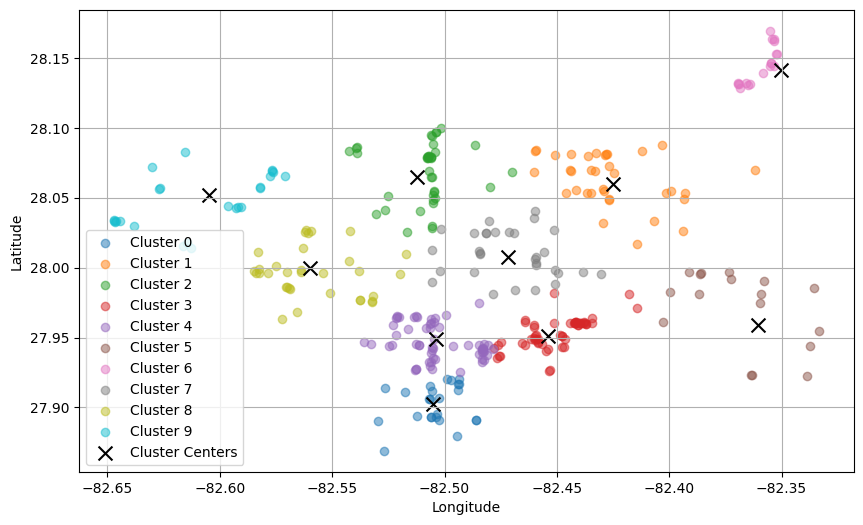

In [63]:
X=city2user_test[['longitude','latitude']]
cluster_pred=city2_kmeans.predict(X)

plt.figure(figsize=(10, 6))

# Plot each cluster separately
for cluster_label in range(city2_kmeans.n_clusters):
    cluster_X = X[cluster_pred == cluster_label]
    plt.scatter(cluster_X['longitude'], cluster_X['latitude'], label=f'Cluster {cluster_label}', alpha=0.5)

# Plot cluster centers
plt.scatter(city2_kmeans.cluster_centers_[:, 0], city2_kmeans.cluster_centers_[:, 1], marker='x', color='black',s=100, label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('KMeans Clustering of City1_test Data')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of the above plot:
We want to highlight that the new/unseen users show a uniform distribution across all the original 10 clusters 

### Thus illustrating that our unseen users belong to all 10 clusters formed and are not placed in just 1 or 2 clusters formed on the training data

### Thus illustrating that our unseen users belong to all 10 clusters formed and are not placed in just 1 or 2 clusters formed on the training data

# Location Based Recommendation (LBR) for a new/unseen user

# Example: Location Based Recommendation for user id =50

In [64]:
# selecting any user for making LBR, let user id = 50
user_id_num=50
buisness_rec_city2=loc_based(user_id_num,city2user_test,city2bus_train,city2_kmeans,rec_k=5)
test_user_loc = city2user_test[['longitude','latitude']].iloc[user_id_num]
print(f'Location of user id {user_id_num}:{test_user_loc} ')
buisness_rec_city2

Location of user id 50:longitude   -82.464137
latitude     27.944866
Name: 50, dtype: float64 


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cluster_no,distance_from_user
54487,XmQRh4JtW82Aki9dmaoJ8A,Cafe European,113 S Hyde Park Ave,Tampa,FL,33629,27.944957,-82.464098,4.5,15,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Salad, Restaurants, Cafes, Sandwiches","{'Monday': '10:0-15:0', 'Tuesday': '10:0-15:0'...",3,0.000099
48755,Hzo_eUL2_9eHAVzIBfH-3g,SoHo Donut Company,117 S Hyde Park Ave,Tampa,FL,33606,27.944934,-82.464049,4.5,71,0,"{'BusinessAcceptsCreditCards': 'True', 'Caters...","Food, Donuts","{'Tuesday': '6:30-18:0', 'Wednesday': '6:30-18...",3,0.000111
32364,kJ3Wh3v2ARoeQxgFFC4PqQ,Max & Chz,117 S Hyde Park Ave,Tampa,FL,33606,27.944934,-82.464049,2.5,19,0,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","American (New), Restaurants, Comfort Food","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",3,0.000111
24752,aPJB_6UOVPCsgp4S5wsekQ,Asian Kitchen,117 S Hyde Park Ave,Tampa,FL,33606,27.944978,-82.464051,4.5,19,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Food, Thai, Noodles, Poke, Asian Fusion, Resta...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",3,0.000140
32040,gXzd2Ao9NNLqCVUOcevdYQ,Chanta European Cuisine,113 S Hyde Park Ave,Tampa,FL,33606,27.945046,-82.464053,4.5,87,1,"{'RestaurantsTableService': 'True', 'BusinessA...","Hungarian, Restaurants, Pizza, German, Modern ...","{'Tuesday': '17:0-23:0', 'Thursday': '17:0-23:...",3,0.000198


# Final Location Based Recommendation for user id =50

In [65]:
buisness_rec_city2 = buisness_rec_city2.rename(columns={'name': 'business_name'})[['business_name', 'categories']].reset_index(drop=True)
buisness_rec_city2

,business_name,categories
0,Cafe European,"Salad, Restaurants, Cafes, Sandwiches"
1,SoHo Donut Company,"Food, Donuts"
2,Max & Chz,"American (New), Restaurants, Comfort Food"
3,Asian Kitchen,"Food, Thai, Noodles, Poke, Asian Fusion, Resta..."
4,Chanta European Cuisine,"Hungarian, Restaurants, Pizza, German, Modern ..."


# Example: Location Based Recommendation for user id =200

In [66]:
# selecting any user for making LBR, let user id = 200

user_id_num=200
buisness_rec_city2=loc_based(user_id_num,city2user_test,city2bus_train,city2_kmeans,rec_k=5)
test_user_loc = city2user_test[['longitude','latitude']].iloc[user_id_num]
print(f'Location of user id {user_id_num}:{test_user_loc} ')
buisness_rec_city2

Location of user id 200:longitude   -82.503860
latitude     28.097044
Name: 200, dtype: float64 


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cluster_no,distance_from_user
5652,a_ts6C7QntisENtyitJRBw,Tanya & Matt's Ice Cream,15742 N Dale Mabry Hwy,Tampa,FL,33618,28.096816,-82.503885,4.0,111,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Ice Cream & Frozen Yogurt, Food, Coffee & Tea","{'Monday': '14:0-21:0', 'Tuesday': '14:0-21:0'...",2,0.000229
47747,RPnTd4XASSFncpsTYnvlsw,Crispers,15726 North Dale Mabry,Tampa,FL,33618,28.096245,-82.504130,3.5,37,0,"{'RestaurantsPriceRange2': '1', 'RestaurantsDe...","American (Traditional), Delis, Restaurants, So...","{'Monday': '10:30-21:0', 'Tuesday': '10:30-21:...",2,0.000844
29172,5m6gQ3BwWi8QXcZmD4yulg,Banh Mi Factory,15728 N Dale Mabry Hwy,Tampa,FL,33618,28.096051,-82.503945,4.5,59,1,"{'OutdoorSeating': 'True', 'RestaurantsDeliver...","Bubble Tea, Bakeries, Sandwiches, Vietnamese, ...","{'Monday': '8:0-20:0', 'Tuesday': '8:0-20:0', ...",2,0.000997
18604,AlMozN7JtyrIDsyrgqRZzw,McDonald's,15698 N Dale Mabry,Tampa,FL,33624,28.095796,-82.502885,2.0,24,1,"{'RestaurantsReservations': 'False', 'GoodForK...","Restaurants, American (New), Food, Burgers, Co...","{'Monday': '4:0-0:0', 'Tuesday': '4:0-0:0', 'W...",2,0.001584
21554,k7Q_5rc3E1t9oxq9QpTMQQ,Taco Bell,16020 Mapledale Blvd,Tampa,FL,33624,28.098408,-82.503029,1.5,27,1,"{'OutdoorSeating': 'False', 'Caters': 'False',...","Fast Food, Mexican, Tacos, Tex-Mex, Restaurant...","{'Monday': '7:0-1:0', 'Tuesday': '7:0-1:0', 'W...",2,0.001597


# Final Location Based Recommendation for user id =200

In [67]:
buisness_rec_city2 = buisness_rec_city2.rename(columns={'name': 'business_name'})[['business_name', 'categories']].reset_index(drop=True)
buisness_rec_city2

,business_name,categories
0,Tanya & Matt's Ice Cream,"Ice Cream & Frozen Yogurt, Food, Coffee & Tea"
1,Crispers,"American (Traditional), Delis, Restaurants, So..."
2,Banh Mi Factory,"Bubble Tea, Bakeries, Sandwiches, Vietnamese, ..."
3,McDonald's,"Restaurants, American (New), Food, Burgers, Co..."
4,Taco Bell,"Fast Food, Mexican, Tacos, Tex-Mex, Restaurant..."


# Location based Recommendations for third city in top 3- Indianapolis

# Populating a dataframe for specific businesses of City 3 (Indianapolis)

In [68]:
city_3=top_k_cities[2]
city3_df=sub2_bus_df[sub2_bus_df['city']==city_3]
city3_df


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
5,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
10,kfNv-JZpuN6TVNSO6hHdkw,Hibachi Express,6625 E 82nd St,Indianapolis,IN,46250,39.904320,-86.053080,4.0,20,1,"{'RestaurantsDelivery': 'True', 'RestaurantsTa...","Steakhouses, Asian Fusion, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
29,seKihQKpGGnCeLuELRQPSQ,Twin Peaks,6880 E 82nd St,Indianapolis,IN,46250,39.906295,-86.047463,3.5,257,1,"{'CoatCheck': 'False', 'Music': '{'dj': False}...","Sports Bars, American (New), American (Traditi...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '..."
30,lOP3HxdUTaq0eXhwR_KC-w,Sweet Things Chocolates,2288 W 86th St,Indianapolis,IN,46260,39.913292,-86.200830,4.0,13,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Chocolatiers & Shops, Specialty Food, Candy St...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'..."
34,7clCBgNbd-x2Wj96lZ6Mjw,Bier Brewery and Tap Room,5133 E 65th St,Indianapolis,IN,46220,39.875532,-86.082857,4.5,139,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Food, Beer, Wine & Spirits, Breweries","{'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56411,8Pw3gUxSISkGqWNOsdWQ4Q,Thai Papaya,"3905 W 96th St, Ste 1000",Indianapolis,IN,46268,39.925550,-86.227468,4.0,132,1,"{'RestaurantsReservations': 'False', 'GoodForK...","Restaurants, Taiwanese, Thai","{'Monday': '0:0-0:0', 'Tuesday': '17:0-21:0', ..."
56513,to0j3ajoWkuPmPWNnwKN8w,Burger King,7430 Rockville Rd,Indianapolis,IN,46214,39.764746,-86.291698,3.0,7,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Burgers, Fast Food, Restaurants","{'Monday': '6:0-23:0', 'Tuesday': '6:0-23:0', ..."
56599,2f1ZnZg7730yChhV24ARJw,Starbucks,5943 S East St,Indianapolis,IN,46227,39.679628,-86.148621,3.5,44,1,"{'WiFi': ''free'', 'BusinessAcceptsCreditCards...","Coffee & Tea, Food","{'Monday': '5:0-21:0', 'Tuesday': '5:0-21:0', ..."
56622,_oJ5QA131I_XnyaXAa8nsA,Starbucks,7800 Colonel H Weir Cook Memorial Dr,Indianapolis,IN,46241,39.715112,-86.297335,2.5,7,0,"{'BusinessParking': '{'garage': False, 'street...","Food, Coffee & Tea","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


In [69]:
# list of name of attributes for the city3_df  along with attributes types
city3_df.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [70]:
# number of null values for each attribute
city3_df.isna().sum() 

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

# Identifying the Top (most frequently occuring) Business categories in the city3_df dataframe

In [71]:
# Initialize a dictionary to store counts
category_counts_city3 = defaultdict(int)

# Iterate through categories in city1_df
for categories_str in city3_df.categories:
    categories = categories_str.split(', ')
    for category in categories:
        category=category.strip()
        # Check if the category is one of the specified categories
        if category in specified_categories:
            # Increment the count for the specified category
            category_counts_city3[category] += 1

# Print counts for each specified category
print('Printing first 20 elements of the dictionary:')
print(list(category_counts_city3 .items())[:20])

Printing first 20 elements of the dictionary:
[('American (Traditional)', 490), ('Restaurants', 2434), ('Breakfast & Brunch', 321), ('American (New)', 336), ('Bars', 558), ('Specialty Food', 195), ('Food', 1167), ('Beer', 104), ('Wine & Spirits', 104), ('Desserts', 145), ('Ice Cream & Frozen Yogurt', 91), ('Pizza', 288), ('Chicken Wings', 200), ('Sandwiches', 381), ('Salad', 195), ('Italian', 134), ('Cafes', 94), ('Coffee & Tea', 274), ('Mexican', 311), ('Seafood', 151)]


In [72]:

# Initialize a dictionary to store counts
category_counts_city3 = defaultdict(int)

# Iterate through categories in city1_df
for categories_str in city3_df.categories:
    categories = categories_str.split(', ')
    for category in categories:
        # Check if the category is one of the specified categories
        if category in specified_categories:
            # Increment the count for the specified category
            category_counts_city3[category] += 1


# Print counts for each specified category
print('Printing first 20 elements of the dictionary:')
print(list(category_counts_city3 .items())[:20])


Printing first 20 elements of the dictionary:
[('American (Traditional)', 490), ('Restaurants', 2434), ('Breakfast & Brunch', 321), ('American (New)', 336), ('Bars', 558), ('Specialty Food', 195), ('Food', 1167), ('Beer', 104), ('Wine & Spirits', 104), ('Desserts', 145), ('Ice Cream & Frozen Yogurt', 91), ('Pizza', 288), ('Chicken Wings', 200), ('Sandwiches', 381), ('Salad', 195), ('Italian', 134), ('Cafes', 94), ('Coffee & Tea', 274), ('Mexican', 311), ('Seafood', 151)]


<AxesSubplot: xlabel='Category'>

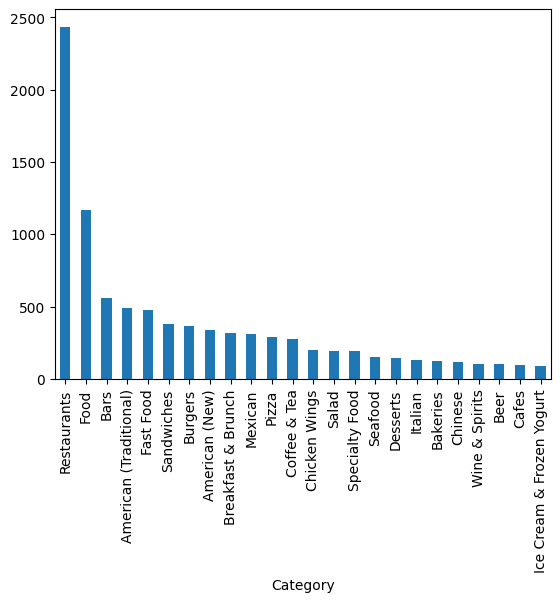

In [73]:
# forming  dataframe out of dictionary to use in pandas
df_cat_city3 = pd.DataFrame(list(category_counts_city3.items()), columns=['Category', 'Count'])
# sorting based on number of counts
df_cat_city3=df_cat_city3.sort_values(by='Count',ascending=False)
# plotting the category count plot for each business in city3
df_cat_city3.plot(x='Category', y='Count', kind='bar',  legend=None)

# Analysis of the plot above:


### The restaurant business is most popular, followed by Food and Bars

# Train-Test Split formation from city3_df (city specific businesses) for the City 3 (Indianapolis) 

In [74]:
city3bus_train, city3bus_test = train_test_split(city3_df, test_size=0.1, random_state=42)
city3bus_train.shape, city3bus_test.shape 

((2736, 14), (305, 14))

# Determining no of Clusters (value of K ) for K-Means using the plot of Inertia (SSE) v/s K in Elbow method 

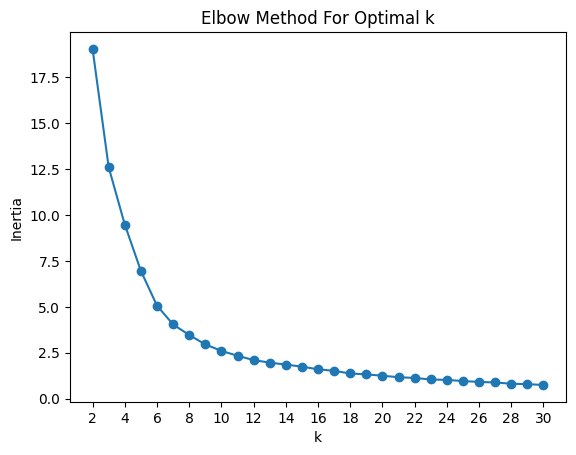

In [75]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = city3bus_train[['longitude','latitude']]

distortions = []
K = range(2,31)
for k in K:
    kmeansModel = KMeans(n_clusters=k,random_state=42)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)


     

fig, ax = plt.subplots()
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(2, 31,2))
plt.title('Elbow Method For Optimal k')
#plt.savefig('elbow.png')
plt.show()
     

 # Determining the goodness of clusters for each K value using Silhouette score

[0.40566373919255677,
 0.4452763168533377,
 0.4645955596877364,
 0.469911782226081,
 0.5161849153816834,
 0.5144873331672851,
 0.5282278467885826,
 0.5364561263095793,
 0.5349795130721865,
 0.5384154734532982,
 0.5407904881965132,
 0.5307617429099022,
 0.5267800549662675,
 0.5273413332910734,
 0.5044492884246053,
 0.46079904372993497,
 0.48368438792009927,
 0.5133539590836335,
 0.4607259536168482,
 0.49048736421533545,
 0.5399330880234696,
 0.47728236784848566,
 0.497950865773542,
 0.4808781549144906,
 0.4905601185617449,
 0.5142846081463365,
 0.49323013647180486,
 0.4995149646123993,
 0.483521254780031]

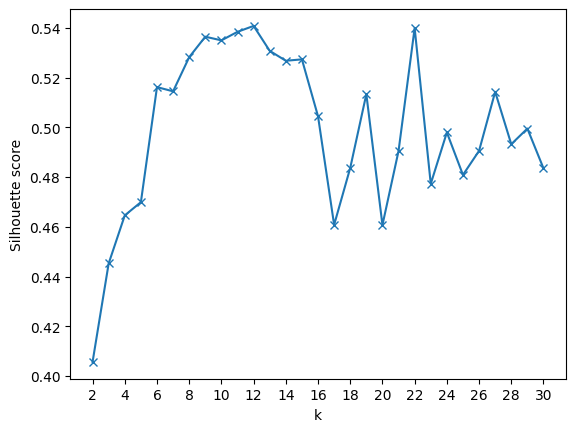

In [76]:
from sklearn.metrics import silhouette_score
coords = city3bus_train[['longitude','latitude']]

sil = []

K = range(2,31)
for k in K:
  kmeans = KMeans(n_clusters = k,random_state=42).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

plt.plot(K, sil, marker='x', label='Silhouette Score')
plt.ylabel('Silhouette score')
plt.xlabel('k')
plt.xticks(range(2, 31,2))
sil

# Selecting appropriate value of K using silhouette score and inertia

In [77]:
pd.DataFrame({'silhouette_score':sil,'Inertia':distortions},index=K)

,silhouette_score,Inertia
2,0.405664,19.050564
3,0.445276,12.606937
4,0.464596,9.483906
5,0.469912,6.961738
6,0.516185,5.067395
7,0.514487,4.042835
8,0.528228,3.470187
9,0.536456,2.957687
10,0.534980,2.603308
11,0.538415,2.337888


# Analysis for selecting K from above: 


### we observe that beyond K=10, the silhouette score and the inertia (SSE) are broadly stable and so we use K=10 

In [78]:

coords = city3bus_train[['longitude','latitude']]

k=10 
city3_kmeans = KMeans(n_clusters=k,random_state=42)
city3_kmeans =city3_kmeans.fit(coords)
y = city3_kmeans.labels_
city3bus_train['cluster_no']=y 

cluster_centers_city3 = city3_kmeans.cluster_centers_


# Plotting the 10 clusters for the City 3 (Indianapolis) using (latitude, longitude) coordinates  

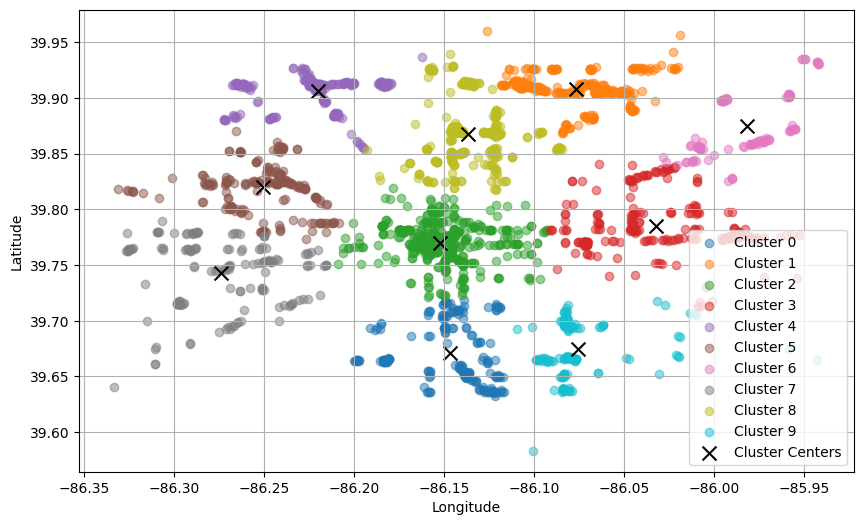

In [79]:
plt.figure(figsize=(10, 6))

# Plot each data point
for cluster_label in range(k):
    plt.scatter(city3bus_train.loc[city3bus_train['cluster_no'] == cluster_label, 'longitude'], 
                city3bus_train.loc[city3bus_train['cluster_no'] == cluster_label, 'latitude'], 
                label=f'Cluster {cluster_label}', alpha=0.5)

# Plot cluster centers
plt.scatter(cluster_centers_city3[:, 0], cluster_centers_city3[:, 1], marker='x', color='black',s=100, label='Cluster Centers',alpha=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('KMeans Clustering of City1bus Data')
plt.legend()
plt.grid(True)
plt.show()


# Using the business locations from the test data (10%) to generate locations for new users wanting location based recommendations

The given user data does not have user locations. So the locations from the unseen data (10%) of businesses of the respective city are used to populate city3user_test data that contains the user id (index of the row) and the user locations (latitude, longitude)

In [80]:
city3user_test=city3bus_test[['longitude','latitude']].reset_index(drop=True)
city3user_test

,longitude,latitude
0,-86.154561,39.762037
1,-86.109100,39.910840
2,-86.122203,39.830054
3,-86.187714,39.693591
4,-86.139186,39.851387
...,...,...
300,-86.153565,39.769633
301,-86.067676,39.911531
302,-86.153605,39.768568
303,-86.112772,39.826393


# The visualisation for the distribution of new/unseen users wrt to the clusters formed earlier, the cluster centers shown by 'X' designate the cluster centers of the clusters formed from the training data

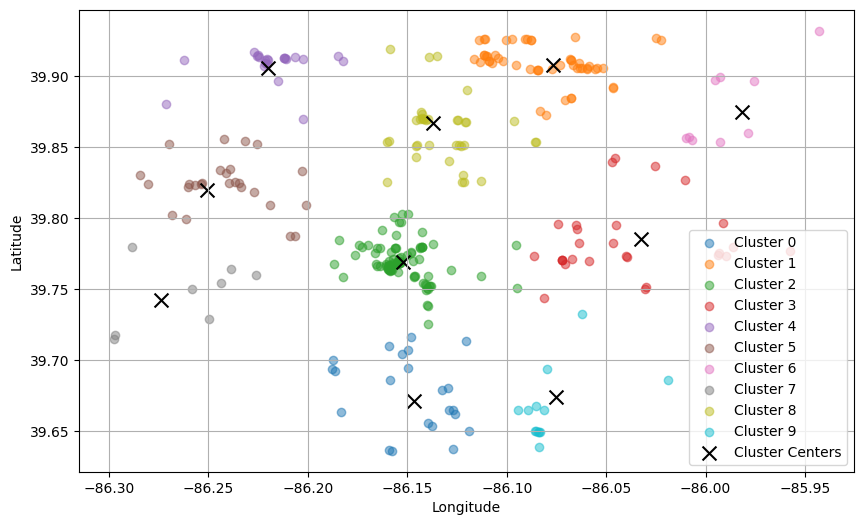

In [81]:
X=city3user_test[['longitude','latitude']]
cluster_pred=city3_kmeans.predict(X)

plt.figure(figsize=(10, 6))

# Plot each cluster separately
for cluster_label in range(city3_kmeans.n_clusters):
    cluster_X = X[cluster_pred == cluster_label]
    plt.scatter(cluster_X['longitude'], cluster_X['latitude'], label=f'Cluster {cluster_label}', alpha=0.5)

# Plot cluster centers
plt.scatter(city3_kmeans.cluster_centers_[:, 0], city3_kmeans.cluster_centers_[:, 1], marker='x', color='black',s=100, label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('KMeans Clustering of City1_test Data')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of the above plot: 


### We want to highlight that the new/unseen users show a uniform distribution across all the original 10 clusters 


### Thus illustrating that our unseen users belong to all 10 clusters formed and are not placed in just 1 or 2 clusters formed on the training data

# Location Based Recommendation (LBR) for a new/unseen user

# Example: Location Based Recommendation for user id =10

In [82]:
# selecting any user for making LBR, let user id = 10
user_id_num=10
buisness_rec_city3=loc_based(user_id_num,city3user_test,city3bus_train,city3_kmeans,rec_k=5)
test_user_loc = city3user_test[['longitude','latitude']].iloc[user_id_num]
print(f'Location of user id {user_id_num}:{test_user_loc} ')
buisness_rec_city3

Location of user id 10:longitude   -86.260130
latitude     39.822164
Name: 10, dtype: float64 


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cluster_no,distance_from_user
22480,JT2BM8SV4lEHMHIakWrNIQ,Taqueria El Maguey,5629 W 38th St,Indianapolis,IN,46254,39.822150,-86.260564,4.0,58,1,"{'NoiseLevel': 'u'average'', 'RestaurantsAttir...","Restaurants, Mexican","{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",5,0.000434
20634,TyBZCT3yOVfrJnMgG0tH4Q,Jack in the Box,5613 W 38th St,Indianapolis,IN,46254,39.823188,-86.259735,2.0,44,1,"{'Ambience': '{'romantic': False, 'intimate': ...","Fast Food, Mexican, Tacos, Restaurants, Breakf...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",5,0.001098
44210,GfhqtLj1DTGonsufL2ZPkw,Steak ’n Shake,5635 W 38th St,Indianapolis,IN,46254,39.823242,-86.260615,2.0,46,0,"{'HasTV': 'False', 'WiFi': ''free'', 'BYOBCork...","Burgers, American (New), Fast Food, American (...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-23:0', '...",5,0.001182
24450,Vqs3w4CaIXmNUBwiZM8N3A,Frankies BBQ,5510 W 38th St,Indianapolis,IN,46254,39.824109,-86.257116,3.0,8,0,"{'Alcohol': 'u'none'', 'WheelchairAccessible':...","Restaurants, Barbeque","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",5,0.003587
28756,MbVZ1yZvG_sSAkHgTUx04A,Havana Cafe,3839 Moller Rd,Indianapolis,IN,46254,39.825106,-86.255694,4.5,211,1,"{'NoiseLevel': ''quiet'', 'RestaurantsGoodForG...","Cuban, Restaurants","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...",5,0.005323


# Final Location Based Recommendation for user id =10

In [83]:
buisness_rec_city3 = buisness_rec_city3.rename(columns={'name': 'business_name'})[['business_name', 'categories']].reset_index(drop=True)
buisness_rec_city3

,business_name,categories
0,Taqueria El Maguey,"Restaurants, Mexican"
1,Jack in the Box,"Fast Food, Mexican, Tacos, Restaurants, Breakf..."
2,Steak ’n Shake,"Burgers, American (New), Fast Food, American (..."
3,Frankies BBQ,"Restaurants, Barbeque"
4,Havana Cafe,"Cuban, Restaurants"


# Example: Location Based Recommendation for user id =50

In [84]:
# selecting any user for making LBR, let user id = 50

user_id_num=50
buisness_rec_city3=loc_based(user_id_num,city3user_test,city3bus_train,city3_kmeans,rec_k=5)
test_user_loc = city3user_test[['longitude','latitude']].iloc[user_id_num]
print(f'Location of user id {user_id_num}:{test_user_loc} ')
buisness_rec_city3

Location of user id 50:longitude   -86.132657
latitude     39.678959
Name: 50, dtype: float64 


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cluster_no,distance_from_user
47518,NIlAb8xuqKyvvqV9mwK6Hg,McDonald's,5935 Madison Ave,Indianapolis,IN,46227,39.680275,-86.131597,2.5,6,1,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...","Coffee & Tea, Food, Fast Food, Burgers, Restau...","{'Monday': '5:30-23:0', 'Tuesday': '5:30-23:0'...",0,0.001689
46273,mjmQXqU9bayL9D11WAwkyA,Donatos Pizza,5835 Madison Ave,Indianapolis,IN,46227,39.681209,-86.131904,2.0,17,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sandwiches, Restaurants, Pizza, Chicken Wings,...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-23:0'...",0,0.002373
52516,kJbAV1ZN65XedfED0HQVsw,Guerreros Mexican Restaurant,"5905 E Madison Ave, Ste A",Indianapolis,IN,46227,39.681139,-86.130094,4.0,49,0,"{'Alcohol': ''beer_and_wine'', 'RestaurantsGoo...","Restaurants, Mexican","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",0,0.003365
30545,zSDrIt1pYh6-UBzqVOBFyA,Great Wall,5855 Madison Ave,Indianapolis,IN,46227,39.680899,-86.129854,2.5,22,1,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","Chinese, Restaurants","{'Monday': '10:45-21:30', 'Tuesday': '10:45-21...",0,0.003409
30700,uhVZoThi0LwX3dI4osVH2w,Old Country Buffet,4200 S E St,Indianapolis,IN,46227,39.680167,-86.124288,3.0,5,0,"{'RestaurantsDelivery': 'False', 'RestaurantsG...","Buffets, Breakfast & Brunch, Restaurants, Amer...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",0,0.008455


# Final Location Based Recommendation for user id =50

In [85]:
buisness_rec_city3 = buisness_rec_city3.rename(columns={'name': 'business_name'})[['business_name', 'categories']].reset_index(drop=True)
buisness_rec_city3

,business_name,categories
0,McDonald's,"Coffee & Tea, Food, Fast Food, Burgers, Restau..."
1,Donatos Pizza,"Sandwiches, Restaurants, Pizza, Chicken Wings,..."
2,Guerreros Mexican Restaurant,"Restaurants, Mexican"
3,Great Wall,"Chinese, Restaurants"
4,Old Country Buffet,"Buffets, Breakfast & Brunch, Restaurants, Amer..."


# End of Location based Recommendation Block